In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 5: Putting it all together 
### Associated lectures: All material till lecture 13
### <u>IMPORTANT NOTE:</u> All students must complete HW5 - this homework grade cannot be dropped as part of the lowest homework grade drop policy.

## Table of contents
0. [Submission instructions](#si)
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)
14. [Your takeaway from the course](#15)

<div class="alert alert-info">

## Submission instructions
<hr>
rubric={points:4}

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
- If you would like to use late tokens for the homework, all group members must have the necessary late tokens available. Please note that the late tokens will be counted for all members of the group.   


Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/master/docs/homework_instructions.md). 

1. Before submitting the assignment, run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Follow the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2024W2/docs/homework_instructions.html), which include information on how to do your assignment and how to submit your assignment.
4. Upload your solution on Gradescope. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope.


_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

</div>

## Final F1-score: 0.5468199953062661

<!-- BEGIN QUESTION -->

## Imports

<div class="alert alert-warning">
    
Imports
    
</div>

_Points:_ 0

In [2]:
import os
import sys
import warnings

warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

pd.set_option("display.max_colwidth", 200)

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.base import clone
import shap 

shap.initjs()


In [3]:
# From code/plotting_functions.py 
def make_num_tree_plot(preprocessor, X_train, y_train, X_test, y_test, num_trees, scoring_metric='f1'):
    """
    Make number of trees vs error rate plot for RandomForestClassifier

    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set
    X_test: numpy.ndarray
        The X part of the test/validation set
    y_test: numpy.ndarray
        The y part of the test/validation set
    num_trees: int
        The value for `n_estimators` argument of RandomForestClassifier
    Returns
    -------
        None
        Shows the number of trees vs error rate plot

    """
    train_scores = []
    test_scores = []
    for ntree in num_trees:
        model = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=ntree,class_weight="balanced", n_jobs=-1, random_state=123))
        scores = cross_validate(
            model, X_train, y_train, return_train_score=True, scoring=scoring_metric
        )
        train_scores.append(np.mean(scores["train_score"]))
        test_scores.append(np.mean(scores["test_score"]))

    plt.semilogx(num_trees, train_scores, label="train")
    plt.semilogx(num_trees, test_scores, label="cv")
    plt.legend()
    plt.title("RandomForestClassifier Tradeoff")
    plt.xlabel("number of trees")
    plt.ylabel("f1-scores") 



def randomized_tuning(pipe, param_grid, n_iter):
    random_search = RandomizedSearchCV(pipe,                                    
                  param_distributions = param_grid, 
                  n_iter=n_iter, 
                  n_jobs=-1, 
                  return_train_score=True,
                  scoring="f1",
                  random_state=123)

    random_search.fit(X_train, y_train)

    result_cols = [
        "mean_test_score",
        "mean_fit_time",
        "rank_test_score"
    ]
    for param in param_grid.keys():
        result_cols.append(f"param_{param}")
    
    display(pd.DataFrame(random_search.cv_results_)[result_cols].set_index("rank_test_score").sort_index().T)

    return random_search

<!-- END QUESTION -->

## Introduction <a name="in"></a>

In this homework you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (15-20 hours???) is a good guideline for this project . Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

<!-- BEGIN QUESTION -->

## 1. Pick your problem and explain the prediction problem <a name="1"></a>
<hr>
rubric={points:3}

In this mini project, you have the option to choose on which dataset you will be working on. The tasks you will need to carry on will be similar, independently of your choice.

### Option 1
You can choose to work on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 


### Option 2
You can choose to work on a regression problem using a [dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) of New York City Airbnb listings from 2019. As usual, you'll need to start by downloading the dataset, then you will try to predict `reviews_per_month`, as a proxy for the popularity of the listing. Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

> Note there is an updated version of this dataset with more features available [here](http://insideairbnb.com/). The features were are using in `listings.csv.gz` for the New York city datasets. You will also see some other files like `reviews.csv.gz`. For your own interest you may want to explore the expanded dataset and try your analysis there. However, please submit your results on the dataset obtained from Kaggle.


**Your tasks:**

1. Spend some time understanding the options and pick the one you find more interesting (it may help spending some time looking at the documentation available on Kaggle for each dataset).
2. After making your choice, focus on understanding the problem and what each feature means, again using the documentation on the dataset page on Kaggle. Write a few sentences on your initial thoughts on the problem and the dataset. 
3. Download the dataset and read it as a pandas dataframe. 

<div class="alert alert-warning">
    
Solution_1
    
</div>

_Points:_ 3

I picked the first problem: Default Credit Card Clients Dataset. I prefer to work with this one because I think it is more intuitive to interpret the columns which are mostly numerical, as opposed to the second dataset which has more categorical features. The problem itself is also more intuitive for me as I am familiar with using credit card, so it's easier to decide which columns I want to use or drop. The columns are the repayment status, amount of bill statement, and previous statement of the past 6 months, in addition to id, limit, sex, education, marriage status, and age. I am going to drop sex since I believe gender doesn't effect whether or not someone will pay their credit card.

In [4]:
creditcard_df = pd.read_csv("data/UCI_Credit_Card.csv", index_col=0)
creditcard_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train (70%) and test (30%) portions with `random_state=123`.

> If your computer cannot handle training on 70% training data, make the test split bigger.  

<div class="alert alert-warning">
    
Solution_2
    
</div>

_Points:_ 2

In [5]:
train_df, test_df = train_test_split(
    creditcard_df, test_size=0.3, random_state=123, stratify=creditcard_df["default.payment.next.month"] #stratify due to class imbalance shown later
)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

<div class="alert alert-warning">
    
Solution_3
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 14452 to 13417
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   21000 non-null  float64
 1   SEX                         21000 non-null  int64  
 2   EDUCATION                   21000 non-null  int64  
 3   MARRIAGE                    21000 non-null  int64  
 4   AGE                         21000 non-null  int64  
 5   PAY_0                       21000 non-null  int64  
 6   PAY_2                       21000 non-null  int64  
 7   PAY_3                       21000 non-null  int64  
 8   PAY_4                       21000 non-null  int64  
 9   PAY_5                       21000 non-null  int64  
 10  PAY_6                       21000 non-null  int64  
 11  BILL_AMT1                   21000 non-null  float64
 12  BILL_AMT2                   21000 non-null  float64
 13  BILL_AMT3                   2100

We can see that for all features/columns, we have 2100 non-nulls, which is the same as the number of samples we have in our training data. Since it seems like no value is missing, no imputer is needed (spoiler: this is false after we do some more EDA below). Here are some of my observation based on the datatype:
- I am dropping SEX for gender equality and avoid historical bias (if any). I believe gender doesn't effect whether or not someone will pay their credit card.
- MARRIAGE has int64 datatype, but we have to see it as categorical
- EDUCATION has int64 datatype. Initially I'd like to use ordinal encoding for this feature so it made sense, but seeing how we have 4='others', it isn't fair to assume it has a lower rank than high school. The client may have completed a higher education that is just not a standard education in Taiwan, therefore it falls to 'others'. Because of this, I decided to make it as categorical feature
- int64 makes sense for PAY, since we may have to do ordinal encoding
- AGE, BILL_AMT, and PAY_AMT are numerical features that has to be scaled (very different range as seen below)

In [7]:
train_df.describe(include='all')

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,167627.318095,1.602476,1.855762,1.551048,35.488476,-0.017429,-0.127810,-0.159238,-0.216095,-0.259524,...,43295.839476,40389.043095,38838.993143,5663.359190,5.990677e+03,5214.520762,4876.729810,4747.745952,5135.359143,0.221190
std,129860.863421,0.489398,0.787604,0.523430,9.224177,1.125270,1.199651,1.203743,1.174019,1.138940,...,64297.470511,60866.714551,59587.880749,16612.876887,2.508848e+04,18035.872826,16423.808259,14813.761614,17679.532366,0.415058
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-28335.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2318.750000,1776.000000,1315.750000,1000.000000,8.557500e+02,390.000000,300.000000,278.750000,109.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19119.500000,18160.500000,17094.500000,2100.000000,2.010500e+03,1800.000000,1500.000000,1509.500000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54928.750000,50229.750000,49286.250000,5001.000000,5.000000e+03,4529.250000,4000.000000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,7.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


Here are some of my observations that doesn't quite make sense:
- min of 0 for MARRIAGE is not consistent with kraggle's provided scale (1=married, 2=single, 3=others)
- min of 0 for EDUCATION is also not consistent with kraggle's provided scale (starts with 1)
- min of -2 for PAY is also not consistent with kraggle's provided scale (starts with -1=pay duly). Upon further research on Kraggle's discussion (https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608), here is what the complete scale looks like:

  **-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; . . .**

  I'd say it is appropriate to use ordinal encoding in this case (-2 best case, 9 worst case)

I am going to assume the 0 values for MARRIAGE and EDUCATION means unknown, not others because they're not the same.

In [8]:
train_df['MARRIAGE'].value_counts()

MARRIAGE
2    11125
1     9596
3      242
0       37
Name: count, dtype: int64

In [9]:
train_df['MARRIAGE'] = train_df['MARRIAGE'].replace(0, np.nan)
test_df['MARRIAGE'] = test_df['MARRIAGE'].replace(0, np.nan)

train_df['MARRIAGE'].value_counts()

MARRIAGE
2.0    11125
1.0     9596
3.0      242
Name: count, dtype: int64

In [10]:
train_df['EDUCATION'].value_counts()

EDUCATION
2    9875
1    7346
3    3451
5     194
4      90
6      32
0      12
Name: count, dtype: int64

Based on Kraggle: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

So, 0,5,6 are unknowns.

In [11]:
train_df['EDUCATION'] = train_df['EDUCATION'].replace({5: np.nan, 6: np.nan, 0: np.nan})
test_df['EDUCATION'] = test_df['EDUCATION'].replace({5: np.nan, 6: np.nan, 0: np.nan})
train_df['EDUCATION'].value_counts()

EDUCATION
2.0    9875
1.0    7346
3.0    3451
4.0      90
Name: count, dtype: int64

Now that we have missing values, we'll have to do imputation later.

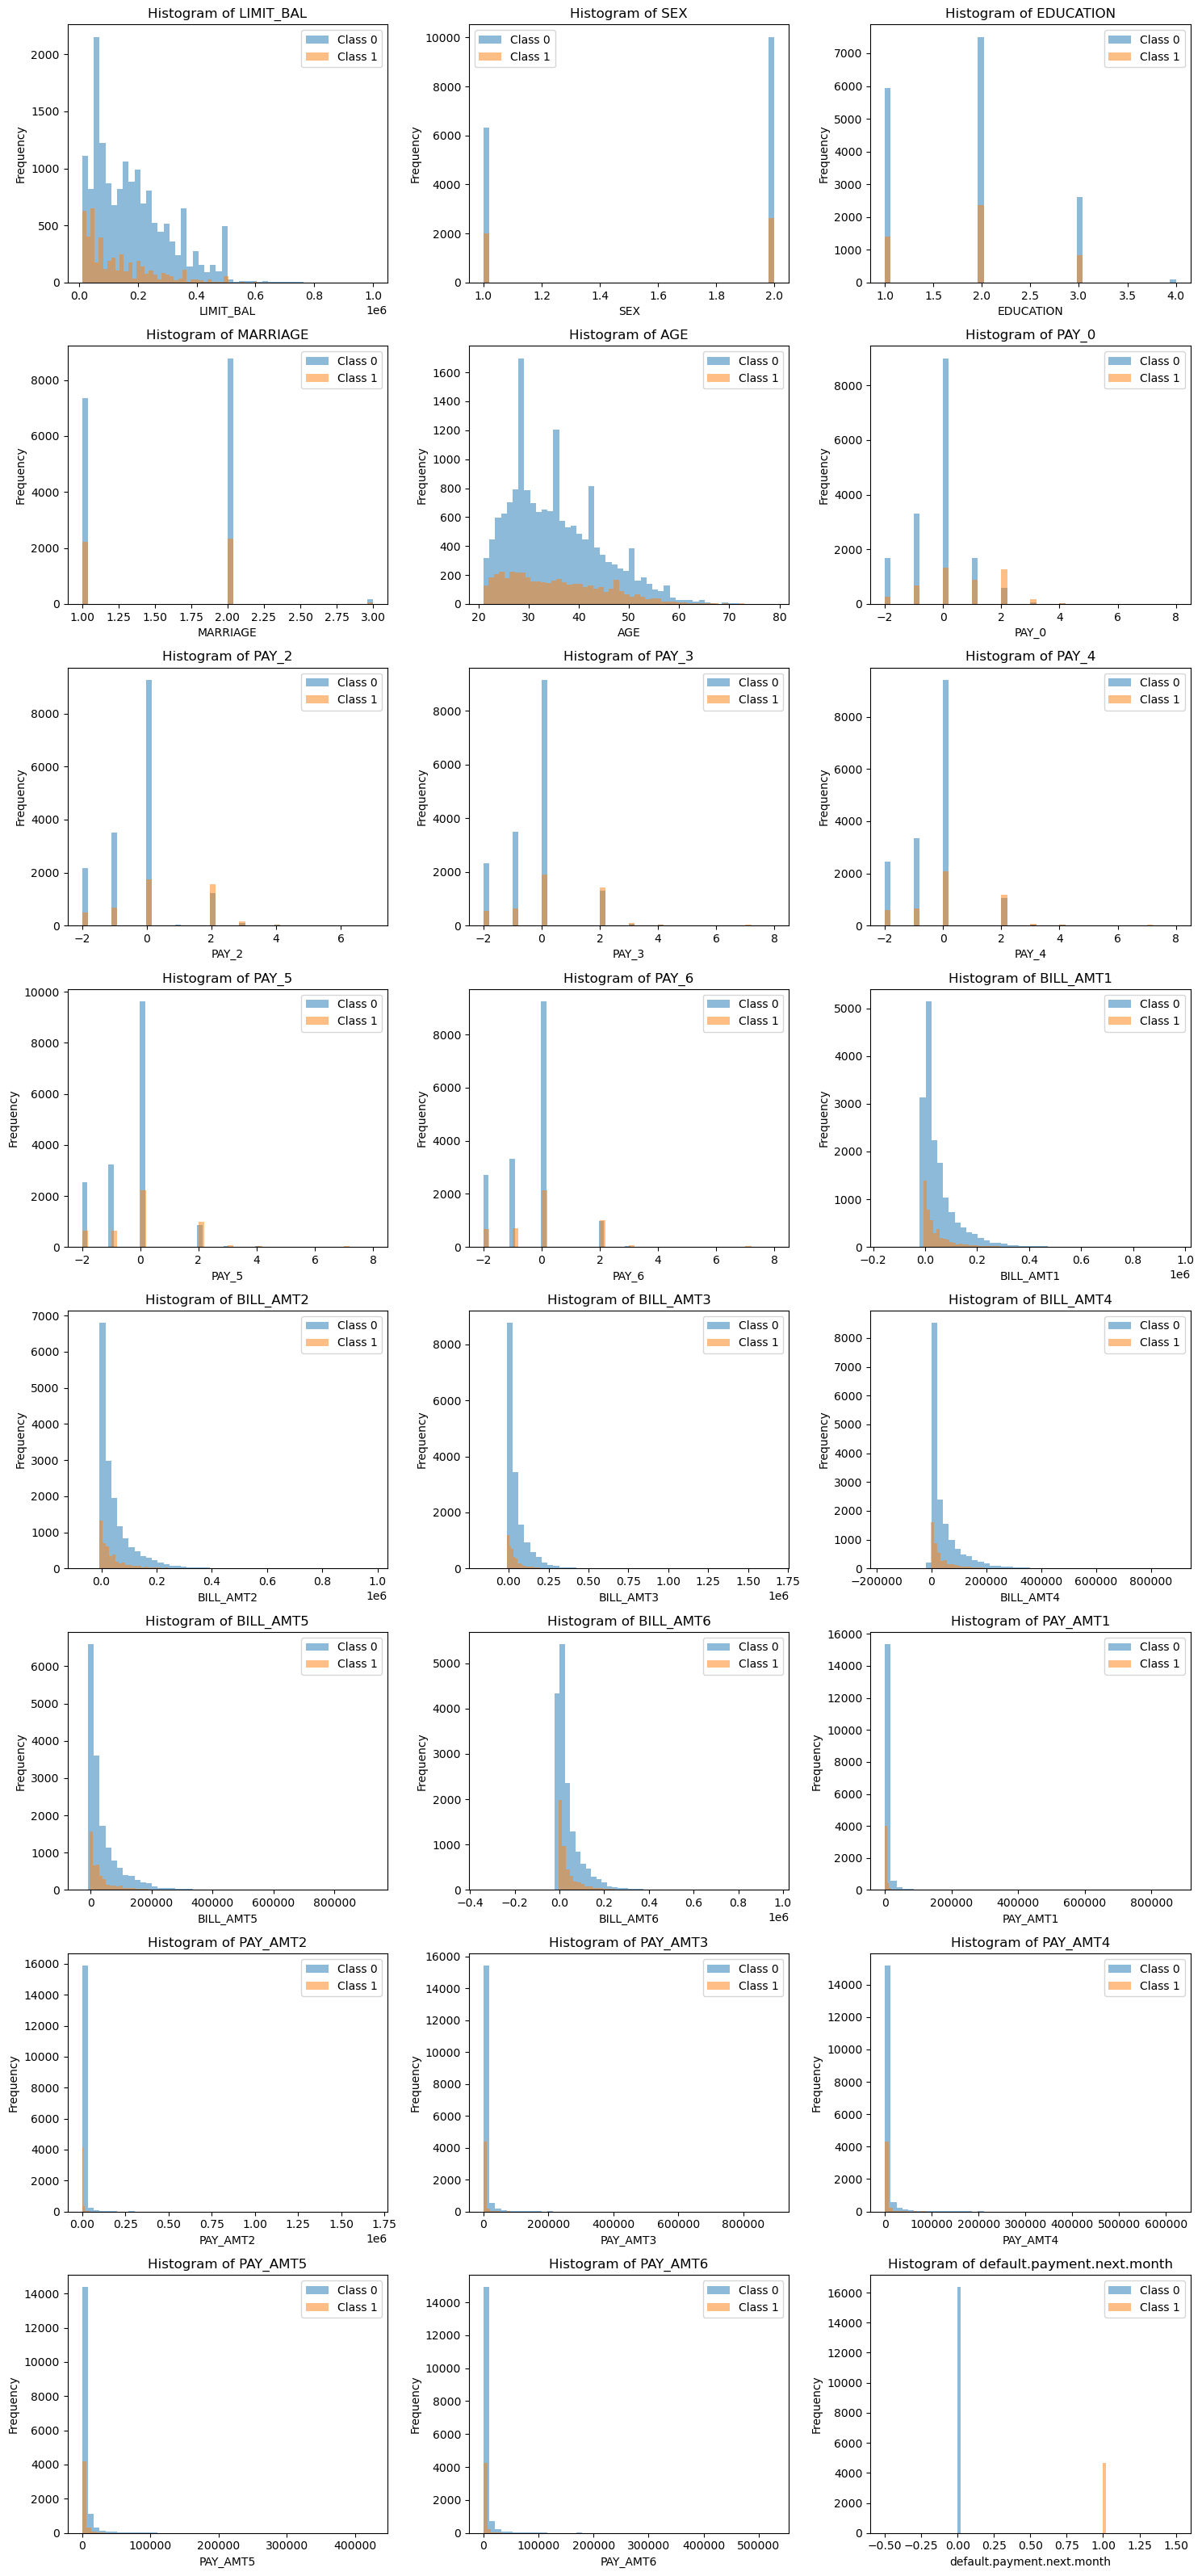

In [12]:
cols=list(train_df.columns.values)
n_cols = 3
n_rows = -(-len(cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten() 

for idx, col in enumerate(cols):
    ax = axes[idx]
    for label, group in train_df.groupby("default.payment.next.month"):
        group[col].plot.hist(bins=50, alpha=0.5, ax=ax, label=f"Class {label}")
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel(col)
    ax.legend()

for i in range(len(cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


It is pretty evident that we have a class imbalance: the blue bars (Class 0) are higher than the orange (Class 1). Turns out, SEX has some variation across the two classes and might seem like a useful feature (even if we scale down the majority class's frequency they're not the same distribution); however I still believe that gender doesn't determine whether someone defaults or not. Furthermore, the binary classification for gender is outdated.

We can also see that the distribution of BILL_AMT and PAY_AMT looks kind of similar for both target classes, just that Class 1 has lower frequency in general. Still, they are not exactly the same. For example, we can see that the clients with negative BILL_AMT are most likely in Class 0 (non-defaulters). This can be very useful! The clients with higher BILL_AMT and PAY_AMT are also most likely in Class 0.

Let's try combining some of these features in another plot for easier analysis. 

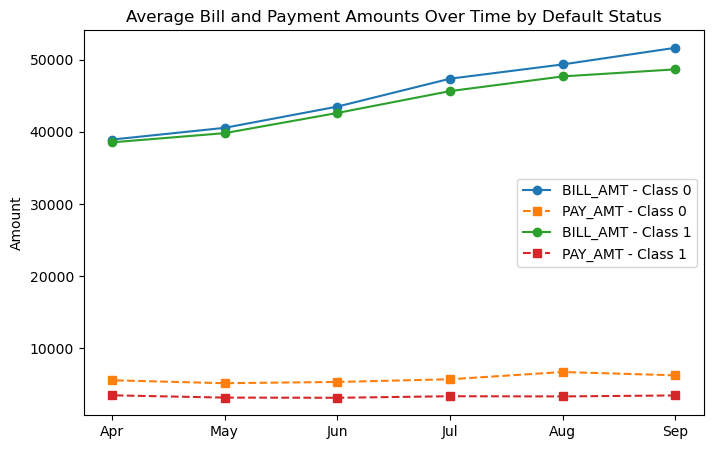

In [13]:
bill_cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
pay_cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
months = ["Sep", "Aug", "Jul", "Jun", "May", "Apr"]

plt.figure(figsize=(8, 5))

for label, group in train_df.groupby("default.payment.next.month"):
    bill_means = group[bill_cols].mean()
    pay_means = group[pay_cols].mean()
    plt.plot(months, bill_means, marker='o', label=f"BILL_AMT - Class {label}")
    plt.plot(months, pay_means, marker='s', linestyle='--', label=f"PAY_AMT - Class {label}")

plt.gca().invert_xaxis()
plt.title("Average Bill and Payment Amounts Over Time by Default Status")
plt.ylabel("Amount")
plt.legend()
plt.show()

So it is true that Class 0 has higher BILL_AMT and PAY_AMT on average. Let's further analyze the difference between these values

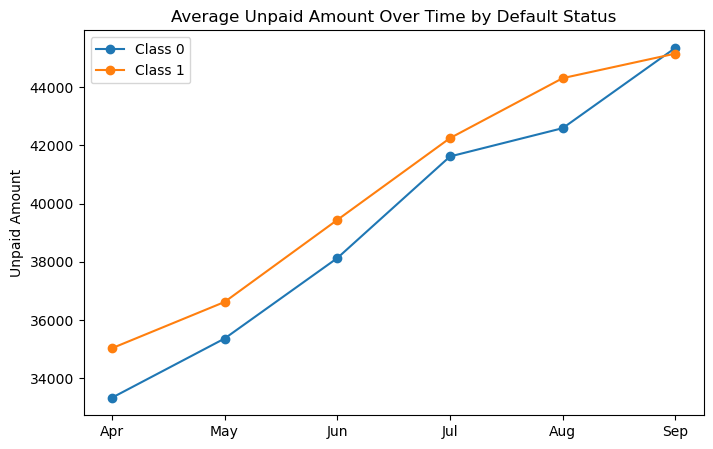

In [14]:
unpaid_df = train_df.copy()
for b_col, p_col in zip(bill_cols, pay_cols):
    unpaid_df[b_col.replace("BILL", "UNPAID")] = unpaid_df[b_col] - unpaid_df[p_col]

unpaid_cols = [col.replace("BILL", "UNPAID") for col in bill_cols]

plt.figure(figsize=(8, 5))

for label, group in unpaid_df.groupby("default.payment.next.month"):
    unpaid_means = group[unpaid_cols].mean()
    plt.plot(months, unpaid_means, marker='o', label=f"Class {label}")

plt.gca().invert_xaxis()
plt.title("Average Unpaid Amount Over Time by Default Status")
plt.ylabel("Unpaid Amount")
plt.legend()
plt.show()

We can see that the defaulters tend to have a higher unpaid amount. This can be a useful feature to add!

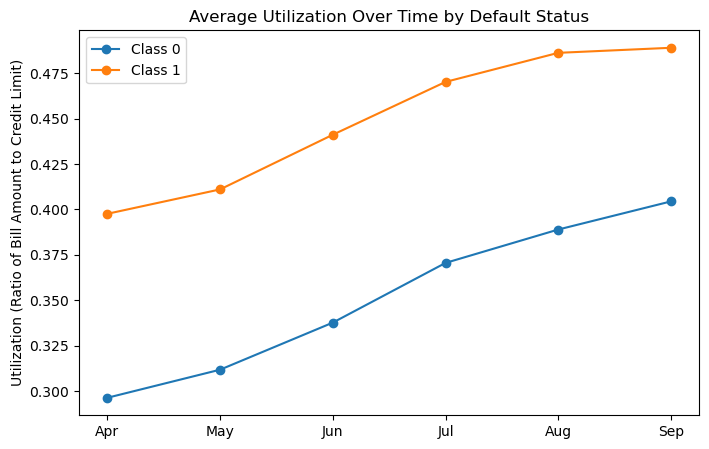

In [15]:
util_df = train_df.copy()
for b_col in bill_cols:
    util_df[b_col.replace("BILL", "UTIL")] = util_df[b_col] / util_df["LIMIT_BAL"]

util_cols = [col.replace("BILL", "UTIL") for col in bill_cols]
plt.figure(figsize=(8, 5))

for label, group in util_df.groupby("default.payment.next.month"):
    avg_utilization = group[util_cols].mean()
    plt.plot(months, avg_utilization, marker='o', label=f"Class {label}")

plt.gca().invert_xaxis()
plt.title("Average Utilization Over Time by Default Status")
plt.ylabel("Utilization (Ratio of Bill Amount to Credit Limit)")
plt.legend()
plt.show()

The plot above also shows another potentialy useful feature I could add. It shows that Class 1 has a higher utilization of their credit card in general (BILL_AMT/LIMIT_BAL).

In [16]:
creditcard_df['default.payment.next.month'].value_counts()

default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

As mentioned before and seen above, we have a class imbalance with the negative class dominating. So accuracy might not be the best metric to use. Since this is a classification problem, I am going to use precision, recall, and F1 score. I am mainly going to look at F1 since it is the harmonic mean of recall and precision, and it is not clear whether we are minimizing false positive or false negative (prioritize precision or recall).

### Summary

- We have a class imbalance so I'm using f1
- Need to do imputation on EDUCATION and MARRIAGE
- Scaling on the numeric features: PAY_AMT{i}, BILL_AMT{i}, LIMIT_BAL, AGE
- OHE on EDUCATION and MARRIAGE
- Ordinal encoding on PAY_{i}
- Drop SEX, keep others
- Some potentially useful features to add: UNPAID_AMT, UTILIZATION, NEGATIVE_BILL

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<div class="alert alert-warning">
    
Solution_4
    
</div>

_Points:_ 1

As seen on the EDA, UNPAID_AMT and UTILIZATION can be a useful feature to add. We have also seen that people who has a negative BILL_AMT are most likely non-defaulters, so I am also adding a binary feature that captures this since BILL_AMT itself will be scaled later and loses it's raw value. Specifically, the new feature shows whether any value of BILL_AMT in any month is negative or not. If there is a negative BILL_AMT in at least one month, the value is set to 1.

Additionally, I am adding the sum of BILL_AMT, PAY_AMT, and UNPAID_AMT across the month, and AVG_UTILIZATION.

In [17]:
for i in range(6):
    col1_name = f"UNPAID_AMT{i+1}"
    train_df[col1_name] = train_df[f"BILL_AMT{i+1}"] - train_df[f"PAY_AMT{i+1}"]
    test_df[col1_name] = test_df[f"BILL_AMT{i+1}"] - test_df[f"PAY_AMT{i+1}"]

    col2_name = f"UTILIZATION{i+1}"
    train_df[col2_name] = train_df[f"BILL_AMT{i+1}"] / train_df["LIMIT_BAL"]
    test_df[col2_name] = test_df[f"BILL_AMT{i+1}"] - test_df["LIMIT_BAL"]

train_df["NEGATIVE_BILL"] = train_df[bill_cols].lt(0).any(axis=1).astype('int')
test_df["NEGATIVE_BILL"] = test_df[bill_cols].lt(0).any(axis=1).astype('int')

train_df["TOTAL_BILL"] = train_df["BILL_AMT1"] + train_df["BILL_AMT2"] + train_df["BILL_AMT3"] + train_df["BILL_AMT4"] + train_df["BILL_AMT5"] + train_df["BILL_AMT6"]
test_df["TOTAL_BILL"] = test_df["BILL_AMT1"] + test_df["BILL_AMT2"] + test_df["BILL_AMT3"] + test_df["BILL_AMT4"] + test_df["BILL_AMT5"] + test_df["BILL_AMT6"]

train_df["TOTAL_PAY_AMT"] = train_df["PAY_AMT1"] + train_df["PAY_AMT2"] + train_df["PAY_AMT3"] + train_df["PAY_AMT4"] + train_df["PAY_AMT5"] + train_df["PAY_AMT6"]
test_df["TOTAL_PAY_AMT"] = test_df["PAY_AMT1"] + test_df["PAY_AMT2"] + test_df["PAY_AMT3"] + test_df["PAY_AMT4"] + test_df["PAY_AMT5"] + test_df["PAY_AMT6"]

train_df["TOTAL_UNPAID"] = train_df["UNPAID_AMT1"] + train_df["UNPAID_AMT2"] + train_df["UNPAID_AMT3"] + train_df["UNPAID_AMT4"] + train_df["UNPAID_AMT5"] + train_df["UNPAID_AMT6"]
test_df["TOTAL_UNPAID"] = test_df["UNPAID_AMT1"] + test_df["UNPAID_AMT2"] + test_df["UNPAID_AMT3"] + test_df["UNPAID_AMT4"] + test_df["UNPAID_AMT5"] + test_df["UNPAID_AMT6"]

train_df["AVG_UTILIZATION"] = (train_df["UTILIZATION1"] + train_df["UTILIZATION2"] + train_df["UTILIZATION3"] + train_df["UTILIZATION4"] + train_df["UTILIZATION5"] + train_df["UTILIZATION6"])/6
test_df["AVG_UTILIZATION"] = (test_df["UTILIZATION1"] + test_df["UTILIZATION2"] + test_df["UTILIZATION3"] + test_df["UTILIZATION4"] + test_df["UTILIZATION5"] + test_df["UTILIZATION6"])/6

Though we have created these potentially useful features, I am still keeping the old features, since some models may be able to extract some useful information out of them (like the individual bill amount across the months, instead of just the sum). 

In [18]:
X_train = train_df.drop(columns=["default.payment.next.month"])
y_train = train_df["default.payment.next.month"]
X_test = test_df.drop(columns=["default.payment.next.month"])
y_test = test_df["default.payment.next.month"]
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,UTILIZATION4,UNPAID_AMT5,UTILIZATION5,UNPAID_AMT6,UTILIZATION6,NEGATIVE_BILL,TOTAL_BILL,TOTAL_PAY_AMT,TOTAL_UNPAID,AVG_UTILIZATION
ID,,,,,,,,,,,,,,,,,,,,,
14452,20000.0,1,3.0,1.0,52,-1,-1,-1,-1,-1,...,0.039000,390.0,0.039000,-390.0,0.019500,0,6032.0,3900.0,2132.0,0.050267
18393,230000.0,2,2.0,2.0,24,-1,-1,-1,-1,-1,...,0.054296,932.0,0.004052,317.0,0.001378,0,14570.0,14583.0,-13.0,0.010558
24956,360000.0,1,3.0,2.0,31,1,-1,2,-1,0,...,0.010361,3930.0,0.010917,3930.0,0.010917,0,12066.0,4168.0,7898.0,0.005586
7163,90000.0,2,2.0,1.0,26,2,0,0,0,0,...,0.977889,84114.0,0.975711,84731.0,0.975900,0,533964.0,23100.0,510864.0,0.988822
12126,20000.0,2,1.0,2.0,29,1,2,0,0,0,...,0.370050,7826.0,0.391300,7252.0,0.377600,0,42329.0,2524.0,39805.0,0.352742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27166,280000.0,1,2.0,1.0,40,1,2,0,0,0,...,0.571961,144421.0,0.551504,151022.0,0.557221,0,1128307.0,34000.0,1094307.0,0.671611
3229,50000.0,2,2.0,1.0,26,0,0,0,0,0,...,0.757440,34448.0,0.714960,32291.0,0.672620,0,235364.0,10485.0,224879.0,0.784547
23478,100000.0,2,2.0,2.0,30,1,2,0,0,2,...,0.343080,34951.0,0.349510,32761.0,0.342610,0,198085.0,8050.0,190035.0,0.330142


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

<div class="alert alert-warning">
    
Solution_5
    
</div>

_Points:_ 10

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 14452 to 13417
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LIMIT_BAL        21000 non-null  float64
 1   SEX              21000 non-null  int64  
 2   EDUCATION        20762 non-null  float64
 3   MARRIAGE         20963 non-null  float64
 4   AGE              21000 non-null  int64  
 5   PAY_0            21000 non-null  int64  
 6   PAY_2            21000 non-null  int64  
 7   PAY_3            21000 non-null  int64  
 8   PAY_4            21000 non-null  int64  
 9   PAY_5            21000 non-null  int64  
 10  PAY_6            21000 non-null  int64  
 11  BILL_AMT1        21000 non-null  float64
 12  BILL_AMT2        21000 non-null  float64
 13  BILL_AMT3        21000 non-null  float64
 14  BILL_AMT4        21000 non-null  float64
 15  BILL_AMT5        21000 non-null  float64
 16  BILL_AMT6        21000 non-null  float64
 17  PAY_AMT1     

In [20]:
numerical_feats = ["LIMIT_BAL", "AGE", 
                 "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
                "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
                  "UNPAID_AMT1", "UNPAID_AMT2", "UNPAID_AMT3", "UNPAID_AMT4", "UNPAID_AMT5", "UNPAID_AMT6",
                "UTILIZATION1", "UTILIZATION2", "UTILIZATION3", "UTILIZATION4", "UTILIZATION5", "UTILIZATION6",
                  "TOTAL_BILL", "TOTAL_PAY_AMT", "TOTAL_UNPAID", "AVG_UTILIZATION"]
ordinal_feats = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
categorical_feats = ["MARRIAGE", "EDUCATION", "NEGATIVE_BILL"]  
drop_feats = ["SEX"]

In [21]:
ord_categories = [list(range(-2, 10))] * 6
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=0),
    OneHotEncoder(drop="if_binary", handle_unknown='ignore'))

ct = make_column_transformer((StandardScaler(), numerical_feats),
                              (categorical_transformer, categorical_feats),
                                (OrdinalEncoder(categories= ord_categories, handle_unknown='use_encoded_value', unknown_value=-3), ordinal_feats))
ct.fit_transform(X_train)
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6', 'UNPAID_AMT1', 'UNPAID_AMT2',
                                  'UNPAID_AMT3', 'UNPAID_AMT4', 'UNPAID_AMT5',
                                  'UNPAID_AMT6', 'UTILIZATION1', 'UTILIZATION2',
                                  'UTILIZATION...
                                 ['MARRIAGE', 'EDUCATION', 'NEGATIVE_BILL']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[[-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8,
                                                             9]],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-3),
                                 ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                  'PAY_6'])])

In [22]:
column_names = (
    numerical_feats
    + ct.named_transformers_['pipeline'].named_steps['onehotencoder'].get_feature_names_out().tolist()
    + ordinal_feats
)
transformed = pd.DataFrame(ct.fit_transform(X_train), columns=column_names)

display(column_names)
display(transformed)

['LIMIT_BAL',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'UNPAID_AMT1',
 'UNPAID_AMT2',
 'UNPAID_AMT3',
 'UNPAID_AMT4',
 'UNPAID_AMT5',
 'UNPAID_AMT6',
 'UTILIZATION1',
 'UTILIZATION2',
 'UTILIZATION3',
 'UTILIZATION4',
 'UTILIZATION5',
 'UTILIZATION6',
 'TOTAL_BILL',
 'TOTAL_PAY_AMT',
 'TOTAL_UNPAID',
 'AVG_UTILIZATION',
 'x0_0.0',
 'x0_1.0',
 'x0_2.0',
 'x0_3.0',
 'x1_0.0',
 'x1_1.0',
 'x1_2.0',
 'x1_3.0',
 'x1_4.0',
 'x2_1.0',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,x1_2.0,x1_3.0,x1_4.0,x2_1.0,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,-1.136839,1.790069,-0.657579,-0.688869,-0.666980,-0.661252,-0.650766,-0.645264,-0.317434,-0.207697,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.480315,-1.245504,-0.695228,-0.691038,-0.671947,-0.479157,-0.648269,-0.646489,-0.326644,-0.215430,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0
2,1.481411,-0.486611,-0.697417,-0.691024,-0.674806,-0.615371,-0.599012,-0.585854,-0.326583,-0.238788,...,0.0,1.0,0.0,0.0,3.0,1.0,4.0,1.0,2.0,2.0
3,-0.597787,-1.028677,0.533114,0.609232,0.598528,0.695443,0.779179,0.822200,-0.039931,-0.067390,...,1.0,0.0,0.0,0.0,4.0,2.0,2.0,2.0,2.0,2.0
4,-1.136839,-0.703437,-0.610613,-0.607924,-0.575633,-0.558275,-0.535002,-0.525069,-0.340910,-0.194224,...,0.0,0.0,0.0,0.0,3.0,4.0,2.0,2.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0.865352,0.489109,2.559857,2.546250,2.080775,1.817427,1.873514,1.966605,-0.340910,0.080091,...,1.0,0.0,0.0,0.0,3.0,4.0,2.0,2.0,2.0,2.0
20996,-0.905817,-1.028677,-0.099286,-0.097953,-0.067065,-0.084357,-0.076251,-0.087402,-0.206794,-0.139138,...,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
20997,-0.520780,-0.595024,-0.263631,-0.256154,-0.216914,-0.139789,-0.089346,-0.076829,-0.340910,-0.165047,...,1.0,0.0,0.0,0.0,3.0,4.0,2.0,2.0,4.0,4.0
20998,1.096374,-0.920264,-0.680165,-0.676517,-0.660036,-0.647706,-0.657174,-0.645264,-0.265003,-0.188524,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model <a name="6"></a>
<hr>
rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

<div class="alert alert-warning">
    
Solution_6
    
</div>

_Points:_ 2

In [23]:
# Adapted from HW 3
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [24]:
score_metrics = ["f1", "precision", "recall"]
results_dict = {}
pipe_dummy = make_pipeline(ct, DummyClassifier(random_state = 123))
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, cv=5, return_train_score=True, scoring = score_metrics
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
dummy,0.047 (+/- 0.002),0.016 (+/- 0.001),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)


In [25]:
train_df["default.payment.next.month"].value_counts()

default.payment.next.month
0    16355
1     4645
Name: count, dtype: int64

Since the dominating target class in the training set is 0 (negative), DummyClassifier always predict 0. Therefore, $TP = FP = 0$. So Precision is set to 0 because it is undefined ($Precision= \frac{TP}{TP+FP} = \frac{0}{0}$). We can also see that Recall is also 0 because $Recall = \frac{TP}{TP+FN} = \frac{0}{FN} = 0$. Since both precision and recall is 0, f1 is also 0

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

<div class="alert alert-warning">
    
Solution_7
    
</div>

_Points:_ 10

In [26]:
pipe_lr = make_pipeline(ct, LogisticRegression(max_iter=1000, class_weight="balanced", random_state=123))
results_dict["Logistic Regression"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, cv=5, return_train_score=True, scoring = score_metrics
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
dummy,0.047 (+/- 0.002),0.016 (+/- 0.001),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.218 (+/- 0.023),0.017 (+/- 0.000),0.475 (+/- 0.010),0.479 (+/- 0.005),0.385 (+/- 0.006),0.387 (+/- 0.006),0.622 (+/- 0.028),0.629 (+/- 0.004)


In [27]:
lr_tuning_results_dict={}
scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
}

for C in scores_dict["C"]:
    pipe_lr = make_pipeline(ct, LogisticRegression(max_iter=1000, class_weight="balanced", C=C, random_state=123))
    lr_tuning_results_dict[C] = mean_std_cross_val_scores(pipe_lr, X_train, y_train, return_train_score=True, scoring = score_metrics)

lr_tuning_results_df = pd.DataFrame(lr_tuning_results_dict).T
lr_tuning_results_df

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
0.0001,0.067 (+/- 0.002),0.017 (+/- 0.000),0.452 (+/- 0.018),0.454 (+/- 0.007),0.355 (+/- 0.014),0.357 (+/- 0.007),0.622 (+/- 0.030),0.625 (+/- 0.005)
0.0010,0.083 (+/- 0.003),0.016 (+/- 0.001),0.472 (+/- 0.013),0.477 (+/- 0.006),0.387 (+/- 0.009),0.390 (+/- 0.010),0.608 (+/- 0.031),0.615 (+/- 0.005)
0.0100,0.127 (+/- 0.007),0.016 (+/- 0.000),0.478 (+/- 0.011),0.482 (+/- 0.005),0.389 (+/- 0.008),0.392 (+/- 0.007),0.619 (+/- 0.028),0.625 (+/- 0.003)
0.1000,0.211 (+/- 0.007),0.017 (+/- 0.000),0.477 (+/- 0.010),0.480 (+/- 0.005),0.387 (+/- 0.006),0.388 (+/- 0.006),0.623 (+/- 0.028),0.627 (+/- 0.004)
1.0000,0.210 (+/- 0.017),0.017 (+/- 0.000),0.475 (+/- 0.010),0.479 (+/- 0.005),0.385 (+/- 0.006),0.387 (+/- 0.006),0.622 (+/- 0.028),0.629 (+/- 0.004)
10.0000,0.218 (+/- 0.037),0.017 (+/- 0.000),0.475 (+/- 0.010),0.479 (+/- 0.005),0.384 (+/- 0.006),0.387 (+/- 0.006),0.622 (+/- 0.028),0.629 (+/- 0.004)
100.0000,0.257 (+/- 0.064),0.017 (+/- 0.001),0.475 (+/- 0.010),0.479 (+/- 0.005),0.385 (+/- 0.005),0.387 (+/- 0.006),0.623 (+/- 0.028),0.629 (+/- 0.004)
1000.0000,0.230 (+/- 0.025),0.017 (+/- 0.001),0.475 (+/- 0.010),0.479 (+/- 0.005),0.385 (+/- 0.006),0.387 (+/- 0.006),0.623 (+/- 0.027),0.629 (+/- 0.004)
10000.0000,0.280 (+/- 0.125),0.017 (+/- 0.000),0.476 (+/- 0.010),0.479 (+/- 0.005),0.385 (+/- 0.006),0.387 (+/- 0.006),0.623 (+/- 0.027),0.629 (+/- 0.004)
100000.0000,0.230 (+/- 0.012),0.017 (+/- 0.000),0.476 (+/- 0.010),0.479 (+/- 0.004),0.385 (+/- 0.006),0.387 (+/- 0.006),0.623 (+/- 0.027),0.629 (+/- 0.004)


As seen, different scoring metric gives different scores, and the best C changes depending on which metric we see, but we are prioritizing f1 score. So I'll take C=0.01 that results in the highest test f1.

In [28]:
best_C = 0.01

In [29]:
pipe_lr = make_pipeline(ct, LogisticRegression(max_iter=1000, C=best_C, class_weight="balanced", random_state=123))
results_dict["Logistic Regression (best C)"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, cv=5, return_train_score=True, scoring = score_metrics
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
dummy,0.047 (+/- 0.002),0.016 (+/- 0.001),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.218 (+/- 0.023),0.017 (+/- 0.000),0.475 (+/- 0.010),0.479 (+/- 0.005),0.385 (+/- 0.006),0.387 (+/- 0.006),0.622 (+/- 0.028),0.629 (+/- 0.004)
Logistic Regression (best C),0.133 (+/- 0.014),0.017 (+/- 0.001),0.478 (+/- 0.011),0.482 (+/- 0.005),0.389 (+/- 0.008),0.392 (+/- 0.007),0.619 (+/- 0.028),0.625 (+/- 0.003)


The standard deviation is low which shows that there is not much variation across the folds, so no optimization bias. Since it is also close with train f1-score, it doesn't seem to be overfitting.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 8. Different models <a name="8"></a>
<hr>
rubric={points:12}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. One of these models should be a tree-based ensemble model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

<div class="alert alert-warning">
    
Solution_8
    
</div>

_Points:_ 12

In [30]:
ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1] # recommended ratio from documentation

In [31]:
# Adapted from lecture 11
pipe_knn = make_pipeline(ct, KNeighborsClassifier())
pipe_rf = make_pipeline(ct, RandomForestClassifier(class_weight="balanced", random_state=123, n_jobs=-1))
pipe_lgbm = make_pipeline(ct, LGBMClassifier(scale_pos_weight=ratio,random_state=123, verbose=-1))

classifiers = {
    "k-NN": pipe_knn,
    "random forest": pipe_rf,
    "LightGBM": pipe_lgbm,
}

for (name, model) in classifiers.items():
    results_dict[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=score_metrics
    )

results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
dummy,0.047 (+/- 0.002),0.016 (+/- 0.001),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.218 (+/- 0.023),0.017 (+/- 0.000),0.475 (+/- 0.010),0.479 (+/- 0.005),0.385 (+/- 0.006),0.387 (+/- 0.006),0.622 (+/- 0.028),0.629 (+/- 0.004)
Logistic Regression (best C),0.133 (+/- 0.014),0.017 (+/- 0.001),0.478 (+/- 0.011),0.482 (+/- 0.005),0.389 (+/- 0.008),0.392 (+/- 0.007),0.619 (+/- 0.028),0.625 (+/- 0.003)
k-NN,0.049 (+/- 0.004),0.664 (+/- 1.256),0.413 (+/- 0.008),0.560 (+/- 0.003),0.533 (+/- 0.014),0.716 (+/- 0.005),0.338 (+/- 0.011),0.460 (+/- 0.003)
random forest,0.781 (+/- 0.127),0.048 (+/- 0.001),0.430 (+/- 0.014),0.998 (+/- 0.000),0.640 (+/- 0.018),0.997 (+/- 0.001),0.324 (+/- 0.012),1.000 (+/- 0.000)
LightGBM,0.203 (+/- 0.006),0.023 (+/- 0.002),0.534 (+/- 0.011),0.688 (+/- 0.001),0.473 (+/- 0.008),0.595 (+/- 0.003),0.615 (+/- 0.018),0.815 (+/- 0.007)


LGBM has the highest f1 scores. In terms of fit and score time, LGBM performs reasonably well too. Similarly, Logistic Regression has a fast performance too since it is a simple model. The other simple model, k-NN, has almost zero fit_time, but its score_time is the highest, due to all the work done during scoring. Logistic Regression on the other hand is fastest in scoring since all it does is compute the score from learned coefficients and bias.

k-NN and RandomForest seem to have the worst performance. Not to mention random forest has quite a longer fit_time, though it's score time is low (DecisionTree-based, yes/no on each node). I think it makes sense for k-NN to not perform well, considering that we have an imbalance dataset. Since k-NN works by selecting nearest neighbors, there is a high chance that the k-closest neighbors of a data point are mostly the majority class. As for Random Forest (and other models), with hyperparameter optimization, it might achieve a more competitive score.

None of them seem to be overfitting, except for random forest that seem to be overfitting. Random forest has an f1 score of almost 1 on train set but fairly low on test set. However, this does not necessarily mean it is overfitting. As seen below, the validation score doesn't decrease when we increase the training score even beyond 100 (default).

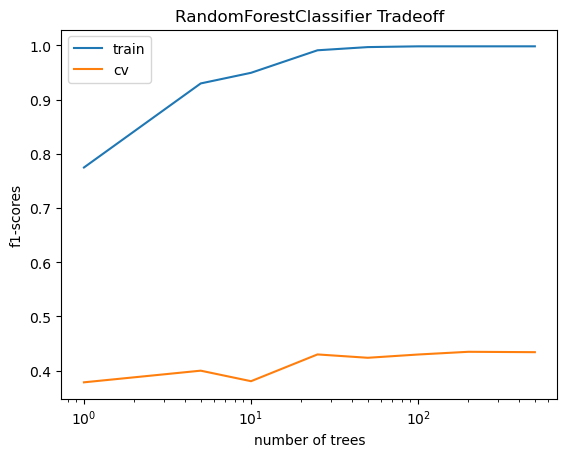

In [32]:
make_num_tree_plot( # defined on cell 3, from lectures/code/plotting_functions.py but tweaked a little
    ct, X_train, y_train, X_test, y_test, [1, 5, 10, 25, 50, 100, 200, 500]
)

From here onward, I am going to work mainly with LogisticRegression, RandomForest, and LGBM.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 9. Feature selection <a name="9"></a>
<hr>
rubric={points:2}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<div class="alert alert-warning">
    
Solution_9
    
</div>

_Points:_ 2

In [33]:
fs_dict={}
X_train_transformed = ct.fit_transform(X_train)
selected_models = ["Logistic Regression (best C)", "random forest", "LightGBM"]
fs_df = results_df.loc[selected_models]
fs_df.index = ["Logistic Regression (pre-select)", "random forest (pre-select)", "LightGBM (pre-select)"]

#### Model-Based Selection 

In [34]:
select_xgb = SelectFromModel(
    XGBClassifier(scale_pos_weight= ratio ,random_state=123, verbosity=0), 
    threshold="median"
)

pipe_lr_model_based = make_pipeline(
    ct, select_xgb, LogisticRegression(max_iter=1000, C=best_C, class_weight="balanced", random_state=123)
)
pipe_rf_model_based = make_pipeline(
    ct, select_xgb, RandomForestClassifier(class_weight="balanced", random_state=123, n_jobs=-1)
)
pipe_lgbm_model_based = make_pipeline(
    ct, select_xgb, LGBMClassifier(scale_pos_weight=ratio,random_state=123, verbose=-1)
)

model_based = {
    "Logistic Regression (model-based)": pipe_lr_model_based,
    "Random Forest (model-based)": pipe_rf_model_based,
    "LightGBM (model-based)": pipe_lgbm_model_based,
}

for (name, model) in model_based.items():
    fs_dict[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=score_metrics
    )

pd.concat([fs_df, pd.DataFrame(fs_dict).T])

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
Logistic Regression (pre-select),0.133 (+/- 0.014),0.017 (+/- 0.001),0.478 (+/- 0.011),0.482 (+/- 0.005),0.389 (+/- 0.008),0.392 (+/- 0.007),0.619 (+/- 0.028),0.625 (+/- 0.003)
random forest (pre-select),0.781 (+/- 0.127),0.048 (+/- 0.001),0.430 (+/- 0.014),0.998 (+/- 0.000),0.640 (+/- 0.018),0.997 (+/- 0.001),0.324 (+/- 0.012),1.000 (+/- 0.000)
LightGBM (pre-select),0.203 (+/- 0.006),0.023 (+/- 0.002),0.534 (+/- 0.011),0.688 (+/- 0.001),0.473 (+/- 0.008),0.595 (+/- 0.003),0.615 (+/- 0.018),0.815 (+/- 0.007)
Logistic Regression (model-based),0.353 (+/- 0.075),0.018 (+/- 0.001),0.476 (+/- 0.006),0.481 (+/- 0.007),0.387 (+/- 0.003),0.391 (+/- 0.009),0.618 (+/- 0.027),0.624 (+/- 0.004)
Random Forest (model-based),0.835 (+/- 0.039),0.049 (+/- 0.001),0.453 (+/- 0.020),0.974 (+/- 0.009),0.612 (+/- 0.014),0.952 (+/- 0.019),0.360 (+/- 0.022),0.997 (+/- 0.002)
LightGBM (model-based),0.397 (+/- 0.015),0.025 (+/- 0.003),0.532 (+/- 0.011),0.664 (+/- 0.005),0.465 (+/- 0.005),0.573 (+/- 0.007),0.620 (+/- 0.022),0.788 (+/- 0.008)


In [35]:
pipe_rf_model_based.fit(X_train, y_train)
support = pipe_lgbm_model_based.named_steps["selectfrommodel"].get_support()
modelbased_selected_features = ct.get_feature_names_out()[support]
print(modelbased_selected_features.size, " features selected:")
modelbased_selected_features

23  features selected:


array(['standardscaler__BILL_AMT1', 'standardscaler__BILL_AMT2',
       'standardscaler__BILL_AMT3', 'standardscaler__PAY_AMT1',
       'standardscaler__PAY_AMT2', 'standardscaler__PAY_AMT4',
       'standardscaler__UNPAID_AMT1', 'standardscaler__UNPAID_AMT3',
       'standardscaler__UNPAID_AMT5', 'standardscaler__UTILIZATION1',
       'standardscaler__UTILIZATION2', 'standardscaler__UTILIZATION6',
       'standardscaler__TOTAL_BILL', 'standardscaler__TOTAL_PAY_AMT',
       'standardscaler__AVG_UTILIZATION', 'pipeline__MARRIAGE_0.0',
       'pipeline__EDUCATION_0.0', 'ordinalencoder__PAY_0',
       'ordinalencoder__PAY_2', 'ordinalencoder__PAY_3',
       'ordinalencoder__PAY_4', 'ordinalencoder__PAY_5',
       'ordinalencoder__PAY_6'], dtype=object)

With model-based selection using XGBoost (chose this because of its shorter compute time than , for example, random forest used on lecture), I don't see any improvement in the test f1-score for LogisticRegression and LGBM, but there is a 0.023 improvement on Random Forest. We also manage to reduce the number of features from 46 to 23. Since our features are not that many to start with, I don't see any problem with keeping all features. However, I will use the selected features for Random Forest since it gives better result.

In [36]:
pipe_rf_selected = pipe_rf_model_based

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:10}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

<div class="alert alert-warning">
    
Solution_10
    
</div>

_Points:_ 10

### Random Forest

Generally n_estimators doesn't need tuning because the more the better, and the trade off is computational cost. I'm keeping n_estimators fairly low to save computation cost.

In [37]:
param_grid_rf = {
    "randomforestclassifier__n_estimators": [250],
    "randomforestclassifier__max_depth": list(range(1,10,1)),
    "randomforestclassifier__max_features": ["log2"] + list(np.arange(0.1,1.1,0.1)),
    "randomforestclassifier__min_samples_split": [1.0] + list(range(2,11,1)),
    "randomforestclassifier__min_samples_leaf": list(range(1,10,1)) + list(np.arange(0.5,1,0.1))
}

best_params_rf = randomized_tuning(pipe_rf_selected, param_grid_rf, 50).best_params_

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,27,27,27,27,27,27,27,27,27,27
mean_test_score,0.542569,0.54252,0.54133,0.541144,0.540696,0.540354,0.539824,0.539109,0.538891,0.538656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_fit_time,8.24928,11.467019,6.540245,14.550528,7.453043,12.162415,15.428432,7.687694,15.013419,11.579616,...,5.85333,8.655742,8.782403,10.667232,10.402235,7.193825,13.145409,5.273256,12.996299,5.291372
param_randomforestclassifier__n_estimators,250,250,250,250,250,250,250,250,250,250,...,250,250,250,250,250,250,250,250,250,250
param_randomforestclassifier__max_depth,6,5,6,6,5,4,7,5,8,3,...,1,9,3,3,8,9,2,1,4,7
param_randomforestclassifier__max_features,0.2,0.2,0.2,log2,0.4,0.4,0.6,0.3,0.6,0.3,...,0.6,0.7,0.8,0.7,0.7,0.5,0.5,0.9,1.0,0.4
param_randomforestclassifier__min_samples_split,9.0,5.0,6.0,4.0,3.0,9.0,10.0,9.0,7.0,3.0,...,3.0,6.0,10.0,6.0,5.0,1.0,9.0,3.0,4.0,7.0
param_randomforestclassifier__min_samples_leaf,5.0,5.0,1.0,7.0,7.0,4.0,1.0,7.0,3.0,9.0,...,0.6,0.9,0.6,0.9,0.9,0.9,0.5,0.8,0.5,0.5


In [38]:
pipe_rf_best = make_pipeline(
    ct, 
    select_xgb, 
    RandomForestClassifier(
        n_estimators=best_params_rf["randomforestclassifier__n_estimators"],
        max_depth = best_params_rf["randomforestclassifier__max_depth"],
        max_features = best_params_rf["randomforestclassifier__max_features"],
        min_samples_split = best_params_rf["randomforestclassifier__min_samples_split"],
        min_samples_leaf = best_params_rf["randomforestclassifier__min_samples_leaf"],
        class_weight="balanced", 
        n_jobs=-1,
        random_state=123)
)

rf_results = mean_std_cross_val_scores(
    pipe_rf_best, X_train, y_train, cv=5, return_train_score=True, scoring = score_metrics
)

In [39]:
pd.concat([
    pd.DataFrame(fs_dict["Random Forest (model-based)"]).T.set_index(pd.Index(["Random Forest (pre-tuned)"])),
    pd.DataFrame(rf_results).T.set_index(pd.Index(["Random Forest (tuned)"]))
])

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
Random Forest (pre-tuned),0.835 (+/- 0.039),0.049 (+/- 0.001),0.453 (+/- 0.020),0.974 (+/- 0.009),0.612 (+/- 0.014),0.952 (+/- 0.019),0.360 (+/- 0.022),0.997 (+/- 0.002)
Random Forest (tuned),1.141 (+/- 0.113),0.079 (+/- 0.009),0.543 (+/- 0.015),0.566 (+/- 0.004),0.498 (+/- 0.014),0.520 (+/- 0.006),0.595 (+/- 0.018),0.622 (+/- 0.011)


This is quite the improvement! The standard deviation is also small, which means the scores are consistent across folds. This means it doesn't overfit on the validation set/no optimization bias.

### LightGBM

In [40]:
param_grid_lgbm = {
    "lgbmclassifier__n_estimators": [250],
    "lgbmclassifier__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.5, 1.0],
    "lgbmclassifier__max_depth": list(range(1,10,1)) + list(range(10,100,5)),
}

best_params_lgbm = randomized_tuning(pipe_lgbm, param_grid_lgbm, 50).best_params_

rank_test_score,1,2,3,3,3,6,7,8,9,10,...,40,42,42,42,42,42,42,42,42,42
mean_test_score,0.544457,0.544374,0.544233,0.544233,0.544233,0.543462,0.542448,0.541389,0.533120,0.532669,...,0.437767,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
mean_fit_time,6.949991,6.458717,7.127204,8.179205,7.276657,1.672949,5.566963,6.518721,1.565146,1.015954,...,7.588172,7.646155,8.323827,7.775887,7.258813,7.588772,5.72818,6.995401,0.853336,8.267929
param_lgbmclassifier__n_estimators,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000
param_lgbmclassifier__learning_rate,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.200000,...,1.000000,0.001000,0.001000,0.001000,0.001000,0.001000,0.00100,0.001000,0.001000,0.001000
param_lgbmclassifier__max_depth,15.000000,10.000000,35.000000,95.000000,40.000000,3.000000,5.000000,7.000000,2.000000,2.000000,...,55.000000,85.000000,80.000000,65.000000,9.000000,30.000000,5.00000,8.000000,1.000000,60.000000


In [41]:
pipe_lgbm_best = make_pipeline(
    ct, 
    LGBMClassifier(
        n_estimators=best_params_lgbm["lgbmclassifier__n_estimators"],
        learning_rate=best_params_lgbm["lgbmclassifier__learning_rate"],
        max_depth=best_params_lgbm["lgbmclassifier__max_depth"],
        random_state=123,
        scale_pos_weight=ratio,
        verbose=-1
    )
)

lgbm_results = mean_std_cross_val_scores(
    pipe_lgbm_best, X_train, y_train, cv=5, return_train_score=True, scoring = score_metrics
)

In [42]:
pd.concat([
    pd.DataFrame(results_df.loc["LightGBM"]).T.set_index(pd.Index(["LightGBM (pre-tuned)"])),
    pd.DataFrame(lgbm_results).T.set_index(pd.Index(["LightGBM (tuned)"]))
])

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
LightGBM (pre-tuned),0.203 (+/- 0.006),0.023 (+/- 0.002),0.534 (+/- 0.011),0.688 (+/- 0.001),0.473 (+/- 0.008),0.595 (+/- 0.003),0.615 (+/- 0.018),0.815 (+/- 0.007)
LightGBM (tuned),0.461 (+/- 0.009),0.031 (+/- 0.003),0.544 (+/- 0.008),0.590 (+/- 0.005),0.493 (+/- 0.005),0.532 (+/- 0.006),0.608 (+/- 0.016),0.663 (+/- 0.004)


There is an improvement in the f1 test score and smaller gap with the train score, so less overfitting. The standard deviation is also small, which means the scores are consistent across folds. This means it doesn't overfit on the validation set/no optimization bias.

### Final Models

In [43]:
pipe_lr_final = pipe_lr
pipe_rf_final = pipe_rf_best
pipe_lgbm_final = pipe_lgbm_best
    

final_models= pd.concat([
    pd.DataFrame(results_df.loc["Logistic Regression (best C)"]).T.set_index(pd.Index(["Logistic Regression (final)"])),
    pd.DataFrame(rf_results).T.set_index(pd.Index(["Random Forest (final)"])),
    pd.DataFrame(lgbm_results).T.set_index(pd.Index(["LightGBM (final)"]))
])
final_models

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
Logistic Regression (final),0.133 (+/- 0.014),0.017 (+/- 0.001),0.478 (+/- 0.011),0.482 (+/- 0.005),0.389 (+/- 0.008),0.392 (+/- 0.007),0.619 (+/- 0.028),0.625 (+/- 0.003)
Random Forest (final),1.141 (+/- 0.113),0.079 (+/- 0.009),0.543 (+/- 0.015),0.566 (+/- 0.004),0.498 (+/- 0.014),0.520 (+/- 0.006),0.595 (+/- 0.018),0.622 (+/- 0.011)
LightGBM (final),0.461 (+/- 0.009),0.031 (+/- 0.003),0.544 (+/- 0.008),0.590 (+/- 0.005),0.493 (+/- 0.005),0.532 (+/- 0.006),0.608 (+/- 0.016),0.663 (+/- 0.004)


It's great that our model's performance have improved, and they are not overfitting. The best performing models are Random Forest and LGBM with almost the same test f1 scores. However, LGBM has a higher train f1 score and therefore bigger gap between the test and train scores (slightly more likely to overfit). On the other side, Random Forest has a higher std on its test f1 score, meaning that it overfit more on the validation set. I personally think these small difference are not a big deal.

Considering how LGBM is twice as fast, and it has a slightly higher f1 test score, I'll pick LGBM as my best model

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Use the methods we saw in class (e.g., `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

<div class="alert alert-warning">
    
Solution_11
    
</div>

_Points:_ 10

#### On Random Forest with sklearn's feature_importances_

In [44]:
# deconstruct pipe_rf_final
rf_preprocessor = pipe_rf_final[:-1]

rf_model  = pipe_rf_final.named_steps["randomforestclassifier"]

In [45]:
X_train_transformed_selected = pd.DataFrame(rf_preprocessor.fit_transform(X_train,y_train))
rf_model.fit(X_train_transformed_selected, y_train)
selected_feature_importance = rf_model.feature_importances_

data = {
    "Importance (model-based selected)": selected_feature_importance,
}
rf_selected_imp_df = pd.DataFrame(
    data=data,
    index=modelbased_selected_features,
).sort_values(by="Importance (model-based selected)", ascending=False)

In [46]:
X_train_transformed = pd.DataFrame(ct.fit_transform(X_train,y_train))
feature_names = ct.get_feature_names_out()

rf_model.fit(X_train_transformed, y_train)
no_selection_feature_importance = rf_model.feature_importances_

data = {
    "Importance (no feature selection)": no_selection_feature_importance,
}
rf_imp_df = pd.DataFrame(
    data=data,
    index=feature_names,
).sort_values(by="Importance (no feature selection)", ascending=False)

In [47]:
df_combined = pd.concat([rf_selected_imp_df, rf_imp_df], axis=1)
df_combined

,Importance (model-based selected),Importance (no feature selection)
ordinalencoder__PAY_0,0.289802,0.280248
ordinalencoder__PAY_2,0.145979,0.144957
ordinalencoder__PAY_3,0.093530,0.093973
ordinalencoder__PAY_4,0.076170,0.058975
ordinalencoder__PAY_5,0.045860,0.045717
standardscaler__TOTAL_PAY_AMT,0.043820,0.040558
standardscaler__PAY_AMT1,0.039962,0.035107
ordinalencoder__PAY_6,0.034306,0.027784
standardscaler__PAY_AMT2,0.028063,0.020906
standardscaler__UTILIZATION2,0.027659,0.021406


In [48]:
selected_feature_importance.size

23

In [49]:
np.sum(selected_feature_importance)

np.float64(0.9999999999999998)

Previously, we have done feature selection with model-based selection with XGBoost, and we are left with 23 features. So the first column shows the importance of these most important 23 features (although according to XGBoost). Their sum equals to 1. Since this is not a linear model, the importance doesn't have a sign.

The columns on the right shows the feature importance of all 46 features of Random Forest. Their sum should also equal to one. I would say the importance of the features are similar to that in column 1. For example, PAY_0 and PAY_2 have the highest importance in both. Each feature of the second column has lower importance in general since there are more features to consider.

Turns out that the most important features are PAY_{i}, particularly PAY_0 and PAY_2. Some of the other less but still important features are TOTAL_PAY_AMT, PAY_AMT{i}, UTILIZATION{i}, AVG_UTILIZATION. Some of our engineered features are among the top features, like TOTAL_PAY_AMT and UTILIZATION{i}. This means that the feature engineering step does help the model. 

I also notice how EDUCATION, MARRIAGE, and AGE turns out to be quite irrelevant. Some even have a 0 (or close to 0 due to truncation/rounding) importance, like MARRIAGE_0 (0:unknown). This means knowing that someone is married or not does not help the model at all.

Although BILL_AMT and UNPAID_AMT still have some importance, they turn out to be less important than I expected.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:10}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain these individual predictions (e.g., with SHAP force plots).  

<div class="alert alert-warning">
    
Solution_12
    
</div>

_Points:_ 10

In [50]:
pipe_lgbm_final.fit(X_train, y_train)
y_pred = pipe_lgbm_final.predict(X_test)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)

F1: 0.5468199953062661
Precision: 0.513215859030837
Recall: 0.5851330989452537


In [51]:
pd.DataFrame(lgbm_results).T.set_index(pd.Index(["LightGBM (cv)"]))

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
LightGBM (cv),0.461 (+/- 0.009),0.031 (+/- 0.003),0.544 (+/- 0.008),0.590 (+/- 0.005),0.493 (+/- 0.005),0.532 (+/- 0.006),0.608 (+/- 0.016),0.663 (+/- 0.004)


2. Yes, the values are pretty much the same. Since the standard deviation on the cv scores of the training set is small, there isn't much variation, so I don't think it suffer from optimization bias (doesn't overfit on validation set) and therefore the results are trusted. The gap between the test and train score are also small, so it doesn't overfit on the training data as well. The similar score on the test set further proves these points.

In [52]:
pipe_lgbm_final.fit(X_train, y_train)

lgbm_model = pipe_lgbm_final.named_steps["lgbmclassifier"]

X_train_enc = pipe_lgbm_final[:-1].transform(X_train)
X_test_enc = pipe_lgbm_final[:-1].transform(X_test)

explainer = shap.TreeExplainer(lgbm_model) 
train_shap_values = explainer(pd.DataFrame(X_train_enc, columns=feature_names))
test_shap_values = explainer(pd.DataFrame(X_test_enc, columns=feature_names)) 

### Example 1

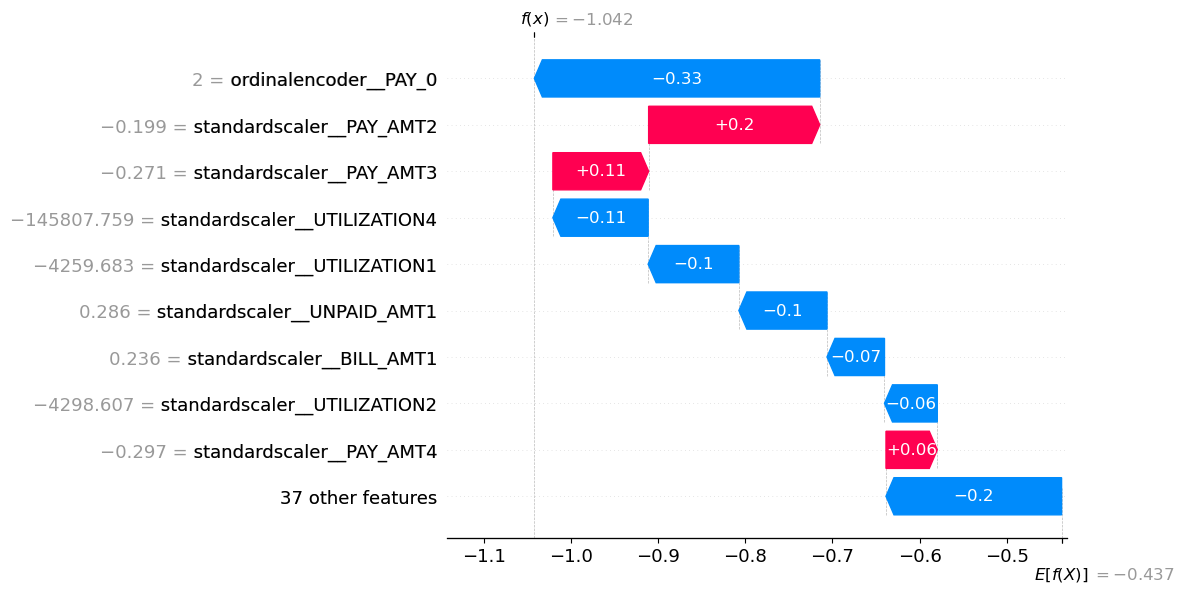

In [53]:
ex1_idx  = 12 
shap.plots.waterfall(test_shap_values[ex1_idx])

In [54]:
print("y actual:", y_test.iloc[ex1_idx])
print("y predicted:", lgbm_model.predict(X_test_enc)[ex1_idx])
lgbm_model.predict_proba(X_test_enc)[ex1_idx]

y actual: 0
y predicted: 0


array([0.73931358, 0.26068642])

In this particular example, the model predicted the correct class (non-defaulters) with around 74% confidence.

The shap plots tell us that the model starts with a base score of E[f(X)]=-0.437. It is the average predicted value for all examples in our training set (mean raw score). After accounting for the values associated with the features, this value moves up (red) and down (blue). The longer the bar, the more and it pushes the value. For example, the feature value PAY_0 = 2 for this particular example contributes the most in making the prediction leans to the negative class. It eventually reaches the score f(X)=-1.042. This value is the raw score:

In [55]:
 lgbm_model.predict(X_test_enc, raw_score=True)[ex1_idx]

np.float64(-1.0424039310714888)

### Example 2

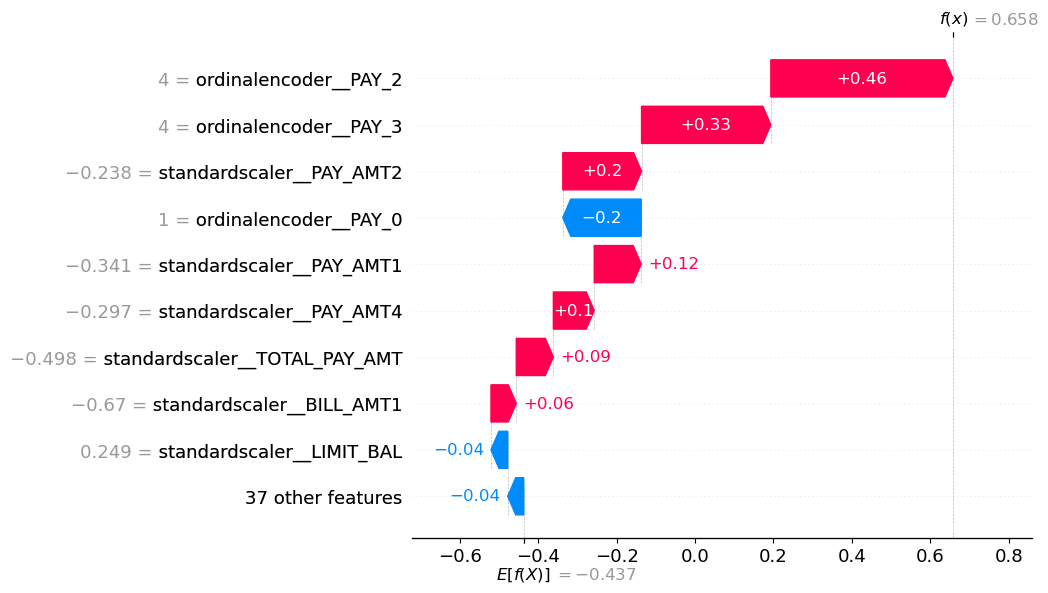

In [56]:
ex2_idx  = 52
shap.plots.waterfall(test_shap_values[ex2_idx])

In [57]:
print("y actual:", y_test.iloc[ex2_idx])
print("y predicted:", lgbm_model.predict(X_test_enc)[ex2_idx])
lgbm_model.predict_proba(X_test_enc)[ex2_idx]

y actual: 0
y predicted: 1


array([0.34118718, 0.65881282])

In this example, the model predicted the wrong class with a 66% confidence.

As shown, the shap plots for this new example starts with the same base score of E[f(X)]=-0.437. However, it has more feature values pushing the score up, causing it to have a final score of 0.658 and predicts the positive class.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Summary of results <a name="13"></a>
<hr>
rubric={points:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

<div class="alert alert-warning">
    
Solution_13
    
</div>

_Points:_ 12

In [58]:
final_models

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
Logistic Regression (final),0.133 (+/- 0.014),0.017 (+/- 0.001),0.478 (+/- 0.011),0.482 (+/- 0.005),0.389 (+/- 0.008),0.392 (+/- 0.007),0.619 (+/- 0.028),0.625 (+/- 0.003)
Random Forest (final),1.141 (+/- 0.113),0.079 (+/- 0.009),0.543 (+/- 0.015),0.566 (+/- 0.004),0.498 (+/- 0.014),0.520 (+/- 0.006),0.595 (+/- 0.018),0.622 (+/- 0.011)
LightGBM (final),0.461 (+/- 0.009),0.031 (+/- 0.003),0.544 (+/- 0.008),0.590 (+/- 0.005),0.493 (+/- 0.005),0.532 (+/- 0.006),0.608 (+/- 0.016),0.663 (+/- 0.004)


After training and optimizing three different models, I decided to use LGBMClassifier as our final model due to its faster performance and highest f1-test score.

### Final model: LGBMClassifier

These are the hyperparameter values I ended up with for our model:

In [59]:
params = lgbm_model.get_params()

params_df = pd.DataFrame([params], index=['Hyperparameter value'])
params_df[["n_estimators","learning_rate","max_depth","random_state","scale_pos_weight"]]

,n_estimators,learning_rate,max_depth,random_state,scale_pos_weight
Hyperparameter value,250,0.01,15,123,3.52099


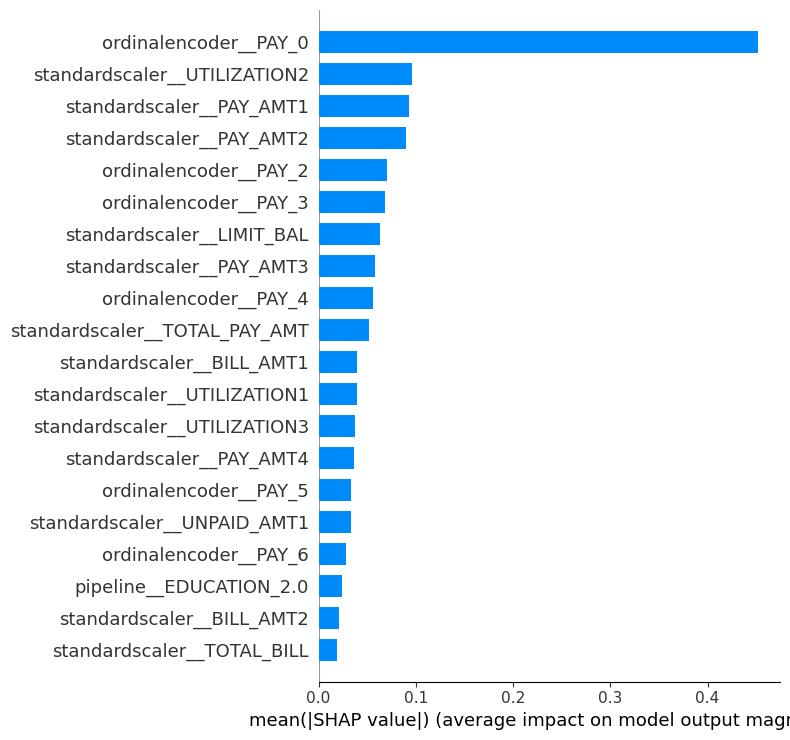

In [60]:
shap.summary_plot(train_shap_values, X_train_enc, plot_type="bar", plot_size=0.3)

It seems like PAY_0 is the feature with the biggest impact on the model's output magnitude, followed by UTILIZATION = BILL/LIMIT_BAL, other PAY_{i}, PAY_AMT, and LIMIT_BAL. Maybe this information can be used for further feature engineering/selection.

In [61]:
data = {
    "Metric": ["F1", "Precision", "Recall"],
    "Test score": [f1, precision, recall],
    "Validation score":[lgbm_results["test_f1"], lgbm_results["test_precision"], lgbm_results["test_recall"]],
    "Train score":[lgbm_results["train_f1"], lgbm_results["train_precision"], lgbm_results["train_recall"]]
}
final_score_df = pd.DataFrame(data)
final_score_df

,Metric,Test score,Validation score,Train score
0,F1,0.546820,0.544 (+/- 0.008),0.590 (+/- 0.005)
1,Precision,0.513216,0.493 (+/- 0.005),0.532 (+/- 0.006)
2,Recall,0.585133,0.608 (+/- 0.016),0.663 (+/- 0.004)


As seen on the table above, our final test score is pretty consistent with the validation and training score. The validation score itself has a small std, which means the scores are consistent across the folds. The gap between the validation and train score is also small. This means our final model is does not overfit on the validation nor the training set.

I still think that our final score is not good enough, mainly due to the class imbalance in the first place. However, compared to my "first real attempt" model (0.475 test_f1), it is a ~15% increase, which isn't too bad. Since the recall is higher, this model would be better if we want to minimize false negatives.

<!-- It also seems like PAY, UTILIZATION, PAY_AMT, and LIMIT_BAL are some features with most impact on the final model's output. Maybe this information can be used for future feature engineering/selection. -->

3. - I initially would like select SVM RBF as one of my main models because its score is close to the highest. However it takes too long to run during hyperparameter optimization so decided to go with other models. I'd like to see how it performs after feature selection and hyperparameter optimization.
    - I'd also like to tune more of the other hyperparameters of LGBM and Random Forest. At the end, I decided to stick with some of the basic ones but I think it could increase the performance a little if I tuned other hyperparameters.
    - I'd like to use RFECV for feature selection, hoping to increase performance time and score; however it took too long so I decided to stick with model-based. I did use it at first, though the score are more or less the same. As I go back and forth doing data pre-processing, running RFECV over and over again took too much of my time.
    - Averaging or stacking

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

## 14. Your takeaway <a name="15"></a>
<hr>
rubric={points:2}

**Your tasks:**

What is your biggest takeaway from the supervised machine learning material we have learned so far? Please write thoughtful answers.  

<div class="alert alert-warning">
    
Solution_14
    
</div>

_Points:_ 2

My biggest takeaway is that building a machine learning model takes a lot of time and effort. Most of my time were spent on <span style="color: red;">*~~waiting for the algorithms to finish running~~*</span> data pre-processing, including feature engineering and selection. It is a lot more than just picking the model that results in the best score and move on; often, I had to go back and forth between the steps. A good knowledge on the dataset is also required in order to build a good model, especially for deciding what additional features would be relevant for the problem.

Even after all that, achieving a high score does not seem as easy as it seems. Example used on lectures often achieve a good score (~0.7 f1-score), so I expected my model to have around the same score. But it turns out to be so much harder to achieve, especially because our dataset is imbalance. And in this case, f1-score is a better metric than accuracy.

Despite that, this is the homework I enjoy working on the most:)

<!-- END QUESTION -->

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

This was a tricky one but you did it! 

![](img/eva-well-done.png)